# Practica 4 Coches

Primero importaremos las librerias necesarias para realizar la clasificacion de este dataset

In [1]:
import pandas as pd
import numpy as np
import sklearn as sl
import matplotlib.pyplot as pl
import seaborn as sns
import scikitplot as skplt
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

pl.style.use('ggplot')

Después, leeremos el csv sobre el que realizaremos el ejercicio

In [2]:
data=pd.read_csv("coches.csv")#Leemos el fichero csv
data

,age,gender,miles,debt,income,sales
0,28,0,23,0,4099,620
1,26,0,27,0,2677,1792
2,30,1,58,41576,6215,27754
3,26,1,25,43172,7626,28256
4,20,1,17,6979,8071,4438
...,...,...,...,...,...,...
958,22,0,11,8778,9829,1593
959,19,1,23,4850,3470,4742
960,28,1,28,9312,2720,12771
961,50,0,29,51343,8713,28511


# 1. Haz todo el preprocesamiento para crear un set de entrenamiento y otro de validación qué permita clasificar rangos de precios que estén dispuestos a pagar que tengan sólo las características necesarias.

Para la realizacion de este primer apartado, primero veremos que variables son necesarias para realizar esta clasificacion. Para ello haremos uso de la libreria seaborn que nos indica que influencia tiene cada variable sobre el resto

<AxesSubplot:>

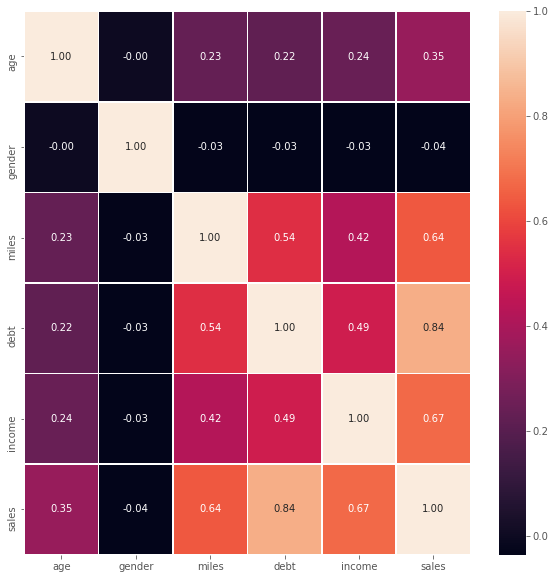

In [3]:
#Mediante el mapa observamos que caracteristicas afectan mas a las ventas
f,ax = pl.subplots(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, linewidths=0.5, fmt= '.2f',ax=ax)

Para asegurarnos, comprobaremos que la realacion indicada por seaborn es correcta mediante el comando corr(), que nos indica la correlacion que existe entre las variables

In [4]:
data.corr()# sin sns

,age,gender,miles,debt,income,sales
age,1.000000,-0.000702,0.232399,0.218896,0.239644,0.352609
gender,-0.000702,1.000000,-0.031355,-0.033181,-0.034317,-0.036350
miles,0.232399,-0.031355,1.000000,0.544791,0.422141,0.636676
debt,0.218896,-0.033181,0.544791,1.000000,0.491790,0.835541
income,0.239644,-0.034317,0.422141,0.491790,1.000000,0.674685
sales,0.352609,-0.036350,0.636676,0.835541,0.674685,1.000000


Tras conocer que caracteristicas son relevantes para hacer este estudio, eliminaremos aquellas columnas que no sean necesarias. En este caso, como hemos podido ver anteriormente, la edad y el genero no influye a la cantidad que hayan pagado por un coche

In [5]:
#Eliminamos dichas columnas
data=data.drop(columns=['age', 'gender'])

Mostramos un resumen de los valores de cada caracteristica usada para el ejercicio, y para conocer de una forma concreta como tendremos que distribuir los rangos de una forma mas correcta. Para ello nos fijaremos dentro de la columna sales, en las filas que van del min al max, y con eso definiremos los rangos.

In [6]:
data.describe()#Utilizamos describe para dividir el rango en secciones de 25%

,miles,debt,income,sales
count,963.000000,963.000000,963.000000,963.000000
mean,27.704050,14109.004154,6176.047767,11689.860852
std,13.378181,18273.702481,3260.670142,8986.896921
min,10.000000,0.000000,0.000000,500.000000
25%,20.000000,1475.000000,3506.500000,3554.000000
50%,25.000000,6236.000000,6360.000000,9130.000000
75%,32.000000,16686.000000,8649.500000,19245.000000
max,97.000000,59770.000000,11970.000000,29926.000000


Para definir los rangos, lo hacemos mediante una lista de condiciones, donde haremos referencia a cada rango de menor a mayor en un numero del 1 al 4 respectivamnete.

In [7]:
#Dividimos las ventas en 4 
conditionlist = [
    (data['sales'] >= 500.0) & (data['sales'] <=3554.0), #0-25
    (data['sales'] >= 3554.0) & (data['sales'] <=9130.0),#25-50
    (data['sales'] >= 9130.0) & (data['sales'] <=19245.0),#50-75
    (data['sales'] > 19245.0)]#75-100
choicelist = [1, 2, 3, 4]
data['sales'] = np.select(conditionlist, choicelist, default='Not Specified')
data

,miles,debt,income,sales
0,23,0,4099,1
1,27,0,2677,1
2,58,41576,6215,4
3,25,43172,7626,4
4,17,6979,8071,2
...,...,...,...,...
958,11,8778,9829,1
959,23,4850,3470,2
960,28,9312,2720,3
961,29,51343,8713,4


Una vez definidos los rangos, tenemos que señalar cuales sean nuestros datos para realizar la clasificacion. En nuestro caso, la 'y' cogera los valores de la variable sobre la que realizaremos la clasificacion, y la 'x', con el resto de caracteristicas, las cuales se utilizaran para predecir futuros valores de 'y'  

In [8]:
#Quitamos 5 filas para utilizarlos en el ultimo apartado
test=data.tail(5)
data.drop(data.tail(5).index,inplace=True)

# 2. Prueba con distintas configuraciones de las dos métricas principales. La primera métrica corresponde al número de individuos que usarás para clasificar una nueva instancia y la segunda cómo vas a medir la cercanía de esa nueva instancia con el resto. ¿Qué decisiones has tomado? ¿Por qué? 

Antes de realizar las configuraciones prepararemos el test de entrenamiento y el de validacion haciendo uso de la funcion'train_test_split' que utilizaremos para identificar que configuracion es mejor.

In [9]:
#Creamos los datos con de entrenamiento y el test
x=data.drop(["sales"],axis=1)
y=data["sales"]
#80% para el training 20%para la validacion
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

Tras definir el test de entrenamiento y el de validacion, ahora pasaremos a configurar como vamos a medir la cercania entre individuos, y cual sera el numero de neighbors que utilizaremos. Para ello haremos uso del algoritmo KNN, y observaremos en el rango de 0-100. 

Para medir la distancia entre los individuos compararemos la distancia euclidea y la de manhattan, solo variaremos el p=1 o p=2, que son distancia euclidea y manhattan respectivamente. La metrica se mantendrá la predeterminada, y veremos, para un mismo numero de vecinos cual clasifica de la mejor forma, y sera la que elegiremos de cara al siguiente apartado.

In [10]:
#Funcion en la que se podra ver la comparacion de ambas configuraciones, manhattan y euclidea
#Creamos un bucle que realice 100 iteraciones empezando en 1 y acabando en 100(100 no incluido) 
#para que se pueda ver el error que se obtiene al aumentar el numero de vecinos

def plot_distancia(distancia):
    #Creacion de las variables donde se guardan tanto el error como el numero de neighbours
    numero=list(range(1, 101))
    error = []
    error = list()
    for i in range (1,101):
        #Definimos el clasificador
        vecinos2=KNeighborsClassifier(n_neighbors=i,weights='distance',p=distancia,metric='minkowski')
        #Entrenamos con el clasificador y los datos de entrenamiento
        vecinos2.fit(x_train,y_train)
        #Mostramos la solucion tras la validacion
        sol=vecinos2.predict(x_test)
        precision=metrics.accuracy_score(y_test,sol)
        #Calculamos el error
        errorpreci=1-precision
        #Guardamos el error en el array
        error.append(errorpreci)
    #Grafica que muestra la disminucion y el posterior aumento del error
    zmin = np.min(error)
    if(distancia==2):
        #Imprimimos el numero del neighbor con el valor del error minimo
        posicion=np.where(min(error) == error)
        posicion=np.asarray(posicion)
        print('El numero de vecino es: '+str(posicion+1))
        print("Minimo error euclidea: "+str(zmin))
        pl.figure(figsize=(30,9))
        pl.plot(numero, error,color='red')
        pl.title('Numero neighbors vs Error EUCLIDEA')
        pl.xticks(numero)
        pl.xlabel('Numero de vecinos')
        pl.ylabel('Error')
        
    else:
        #Imprimimos el numero del neighbor con el valor del error minimo
        posicion=np.where(min(error) == error)
        posicion=np.asarray(posicion)
        print('El numero de vecino es: '+str(posicion+1))
        print("Minimo error manhattan: "+str(zmin))
        pl.figure(figsize=(30,9))
        pl.plot(numero, error,color='blue')
        pl.title('Numero neighbors vs Error MANHATTAN')
        pl.xticks(numero)
        pl.xlabel('Numero de vecinos')
        pl.ylabel('Error')
pl.show()
    
    

Distancia Euclidea

El numero de vecino es: [[15 18 43 46 73]]
Minimo error euclidea: 0.34375


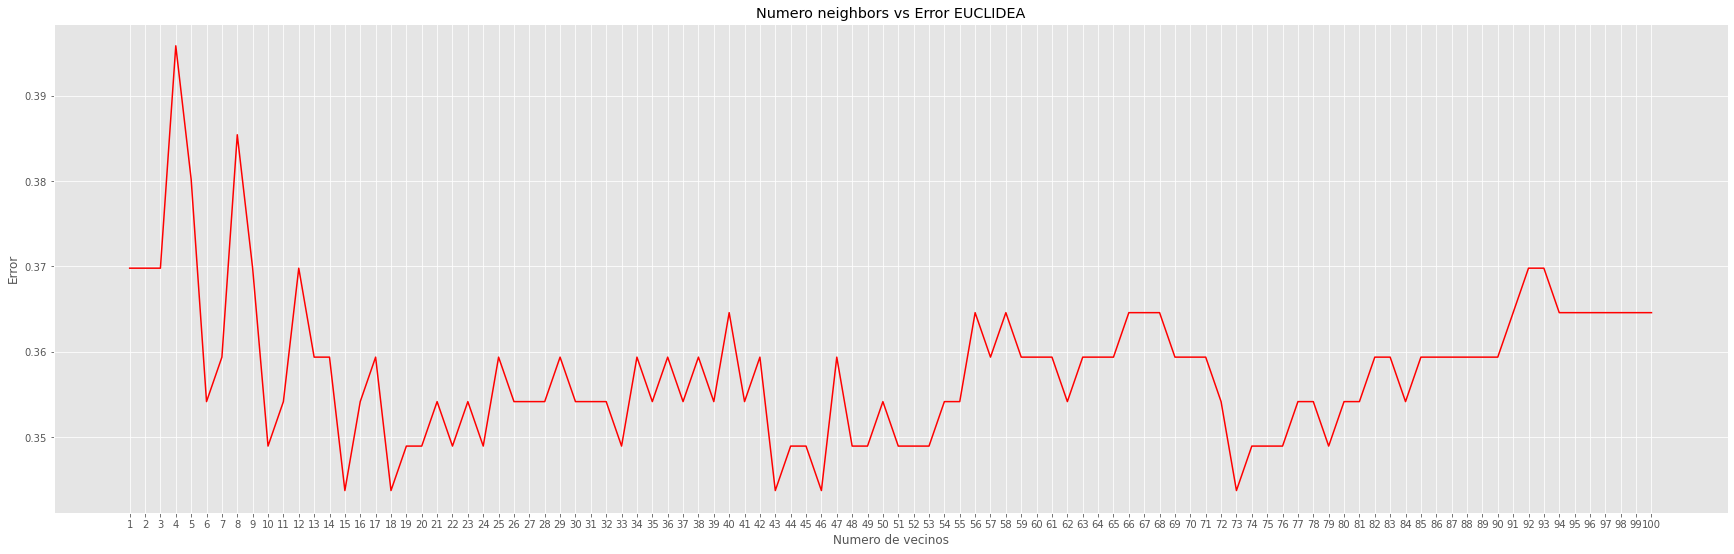

In [11]:
plot_distancia(2)

Distancia Manhattan

El numero de vecino es: [[19 21]]
Minimo error manhattan: 0.328125


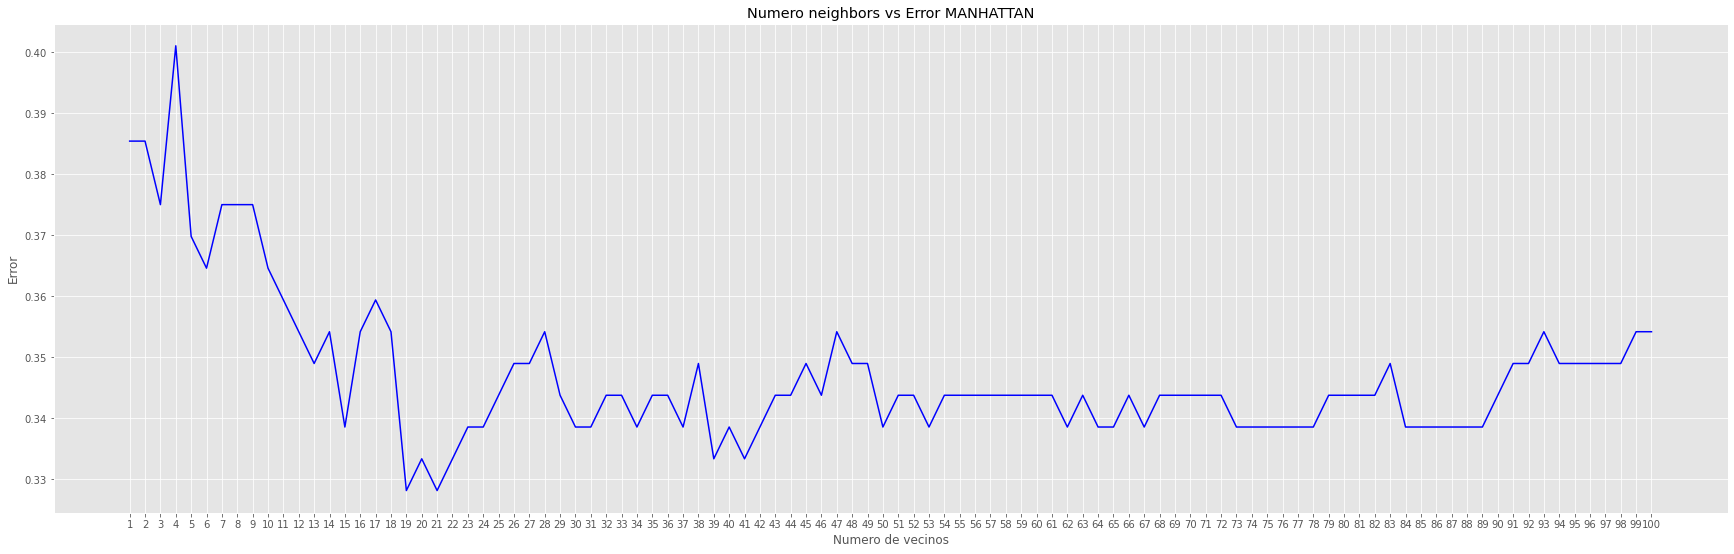

In [12]:
plot_distancia(1)

Como podemos ver al comparar las graficas que hacen referencia al error que se obtiene al variar el numero de vecinos desde 1 hasta 100 segun la distancia euclidea y la distancia de manhattan, el error minimo globlal, es decir, entre las dos distancias, lo obtenemos con la distancia de manhattan obteniendo un error de 0.328125 respecto al minimo error de la distancia euclidea que es 0.34375, por lo que para el siguiente apartado, haremos uso de la distancia de manhattan con la metrica predeterminada de 'minkowski' utilizando 19 vecinos. 

In [13]:
#Definimos el clasificador despues explicaremos la razon por la que hemos escogido 19
knn=KNeighborsClassifier(n_neighbors=19,weights='distance',p=1,metric='minkowski')
#Entrenamos con el clasificador y los datos de entrenamiento
knn.fit(x_train,y_train)
#Mostramos la solucion tras la validacion y una serie de caracteristicas, ademas de la matriz de confusion
pred=knn.predict(x_test)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test, pred))
print("Accuracy:",metrics.accuracy_score(y_test,pred))

[[35 10  3  0]
 [10 21 18  0]
 [ 2 12 22  5]
 [ 0  0  3 51]]
              precision    recall  f1-score   support

           1       0.74      0.73      0.74        48
           2       0.49      0.43      0.46        49
           3       0.48      0.54      0.51        41
           4       0.91      0.94      0.93        54

    accuracy                           0.67       192
   macro avg       0.66      0.66      0.66       192
weighted avg       0.67      0.67      0.67       192

Accuracy: 0.671875


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

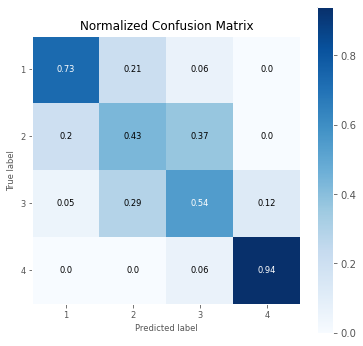

In [14]:
#Matriz de confusion
skplt.metrics.plot_confusion_matrix(y_test, knn.predict(x_test),normalize=True,figsize=(6,6),text_fontsize='small')

# 3. Elige la mejor configuración entre las anteriores. Para ello dibuja una tabla ver cómo evoluciona la clasificación.  Dibuja  los  resultados  que  se  obtienen  con  ambas  configuraciones  elegidas  cómo  las mejores

In [15]:
#Creamos variables donde se guardaran los datos del error y del numero de neighbours
#Variable que contiene los numeros del 1 al 100
numero=list(range(1, 101))

#Variable que guarda el error del clasificador en funcion del numero de vecinos
error = []
error = list()

In [16]:
#Creamos un bucle que realice 30 iteraciones empezando en 1 y acabando en 31(31 no incluido) 
#para que se pueda ver el error que se obtiene al aumentar el numero de vecinos
for i in range (1,101):
    #Definimos el clasificador
    vecinos2=KNeighborsClassifier(n_neighbors=i,weights='distance',p=1,metric='minkowski')
    #Entrenamos con el clasificador y los datos de entrenamiento
    vecinos2.fit(x_train,y_train)
    #Mostramos la solucion tras la validacion
    sol=vecinos2.predict(x_test)
    precision=metrics.accuracy_score(y_test,sol)
    #Calculamos el error
    errorpreci=1-precision
    #Guardamos dentro de la variable error
    error.append(errorpreci)


In [17]:
#Creacion de la tabla donde se muestra la disminucion del error al aumentar el numero de vecinos hasta cierto punto
# El punto en el que se obtiene el minimo error es 19 y 21
tabla = pd.DataFrame({"Neighbours": numero,"Error": error})
tabla

,Neighbours,Error
0,1,0.385417
1,2,0.385417
2,3,0.375000
3,4,0.401042
4,5,0.369792
...,...,...
95,96,0.348958
96,97,0.348958
97,98,0.348958
98,99,0.354167


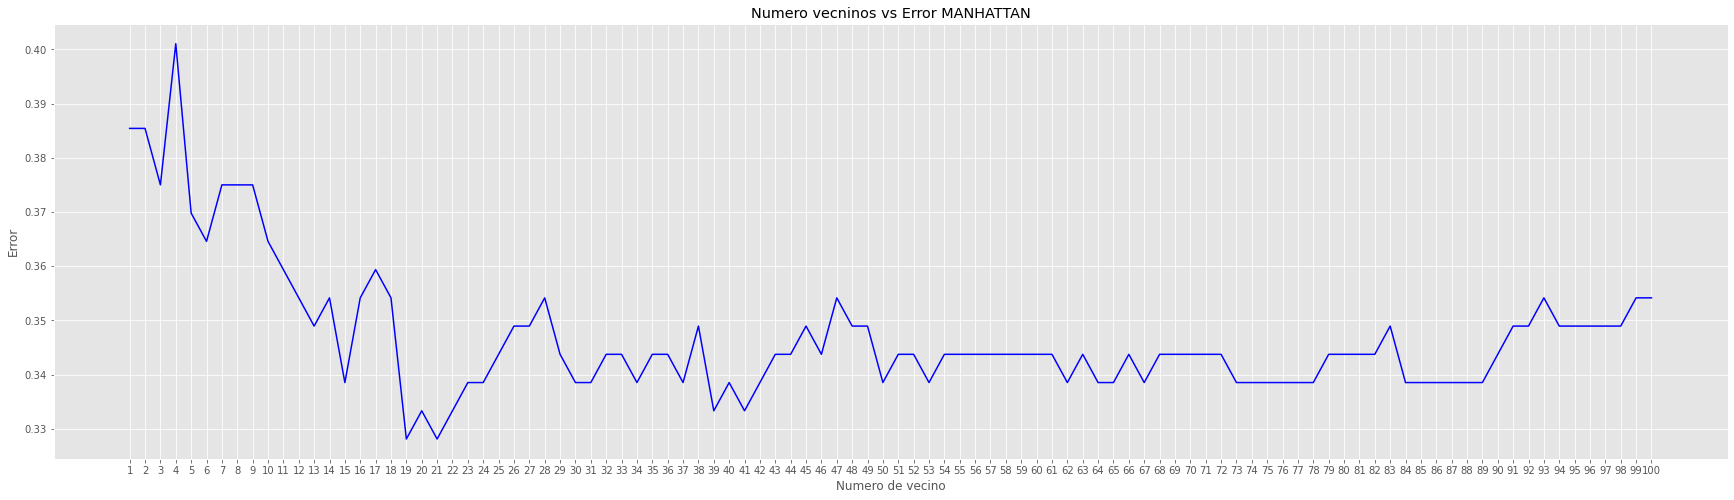

In [18]:
#Grafica que muestra la disminucion y el posterior aumento del error
pl.figure(figsize=(30,8))
pl.plot(numero, error,color='blue')
pl.title('Numero vecninos vs Error MANHATTAN')
pl.xticks(numero)
pl.xlabel('Numero de vecino')
pl.ylabel('Error')
pl.show()

Como podemos ver al aumentar el numero de neighbours el error desciende dado que aumenta la precision

# 4. Utiliza  el  clasificador  para  saber  que  ocurre  con  los datos  de  un  nuevo dataset  que  se  llame “dispuestoapagar_clasificar.csv” que obtendremos del dataset proporcionado

In [19]:
test#Ultimas 5 filas del dataset proporcionado

,miles,debt,income,sales
958,11,8778,9829,1
959,23,4850,3470,2
960,28,9312,2720,3
961,29,51343,8713,4
962,15,3735,6406,2


In [20]:
#Creamos el csv con el nombre indicado
test.to_csv('dispuestoapagar_clasificar.csv', index=False)

In [21]:
#Creamos los datos con de entrenamiento y el test
x_test=test.drop(["sales"],axis=1)
y_test=test["sales"]

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

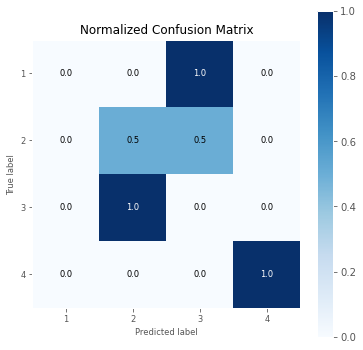

In [22]:
#Matriz de confusion del clasificador con los nuevos datos
skplt.metrics.plot_confusion_matrix(y_test, knn.predict(x_test),normalize=True,figsize=(6,6),text_fontsize='small')

In [23]:
#Matriz de confusion
confusion_matrix(knn.predict(x_test), y_test)

array([[0, 0, 0, 0],
       [0, 1, 1, 0],
       [1, 1, 0, 0],
       [0, 0, 0, 1]])